<h1>Configuration of the environment</h1>

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn_pandas
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Activation, Dropout
from keras import backend as K
from imblearn.over_sampling import SMOTENC
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, f1_score

!pip install keras

<h1>Load the data</h1>

In [28]:
xtrain=pd.read_csv("/content/X_train.csv",sep=",")
ytrain=pd.read_csv("/content/y_train.csv",sep=",")
dataset=xtrain.merge(ytrain,on="ID",how='left')
dataset

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,21754,80000.0,2,2,2,24,0,0,0,0,0,0,75125.0,77353.0,78321.0,73731.0,39643.0,39457.0,3503.0,5001.0,2092.0,1218.0,1445.0,878.0,0
1,252,30000.0,1,2,2,28,0,0,0,0,0,0,29242.0,29507.0,29155.0,25255.0,22001.0,0.0,5006.0,1244.0,851.0,955.0,0.0,0.0,0
2,22942,180000.0,2,5,1,44,0,0,-1,-1,-1,-1,20916.0,0.0,850.0,0.0,6881.0,10340.0,0.0,850.0,0.0,6881.0,10340.0,182.0,0
3,619,60000.0,1,1,2,25,0,0,0,0,0,0,58839.0,53235.0,38533.0,39639.0,39619.0,39140.0,2018.0,1900.0,2000.0,1500.0,1900.0,2000.0,0
4,17091,130000.0,2,2,2,25,0,0,0,0,0,0,111587.0,112348.0,114734.0,117823.0,120854.0,123904.0,4100.0,4200.0,5000.0,5000.0,5000.0,10700.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,29803,50000.0,1,2,2,32,0,0,0,0,0,0,52475.0,53600.0,55739.0,55957.0,29238.0,6119.0,2000.0,3000.0,1591.0,72.0,1134.0,73421.0,0
23996,5391,200000.0,1,1,2,37,2,2,2,2,2,2,157131.0,166590.0,168386.0,164182.0,169029.0,172084.0,13500.0,6000.0,0.0,7500.0,6000.0,4000.0,1
23997,861,50000.0,1,1,2,26,-2,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
23998,15796,70000.0,2,2,2,25,0,0,0,0,2,2,73939.0,70488.0,51152.0,35122.0,28633.0,28039.0,3000.0,2000.0,4500.0,1200.0,0.0,1200.0,1


<h1>Dataset exploration</h1>

In [29]:
def draw_plots():
  fig=plt.figure(num=None, figsize=(20, 25), dpi=80, facecolor='w', edgecolor='k')

  bar_plot = ["default.payment.next.month", "SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]

  pos = 1
  for attrib in set(dataset.columns.values) - set(["ID"]):
    if attrib not in bar_plot:
      plt.subplot(6, 4, pos)
      plt.hist(dataset[attrib])
      plt.title(attrib)
    else:
      plt.subplot(6, 4, pos)
      dataset[attrib].value_counts().plot(kind = 'bar')
      plt.title(attrib)
    pos += 1

  plt.show()

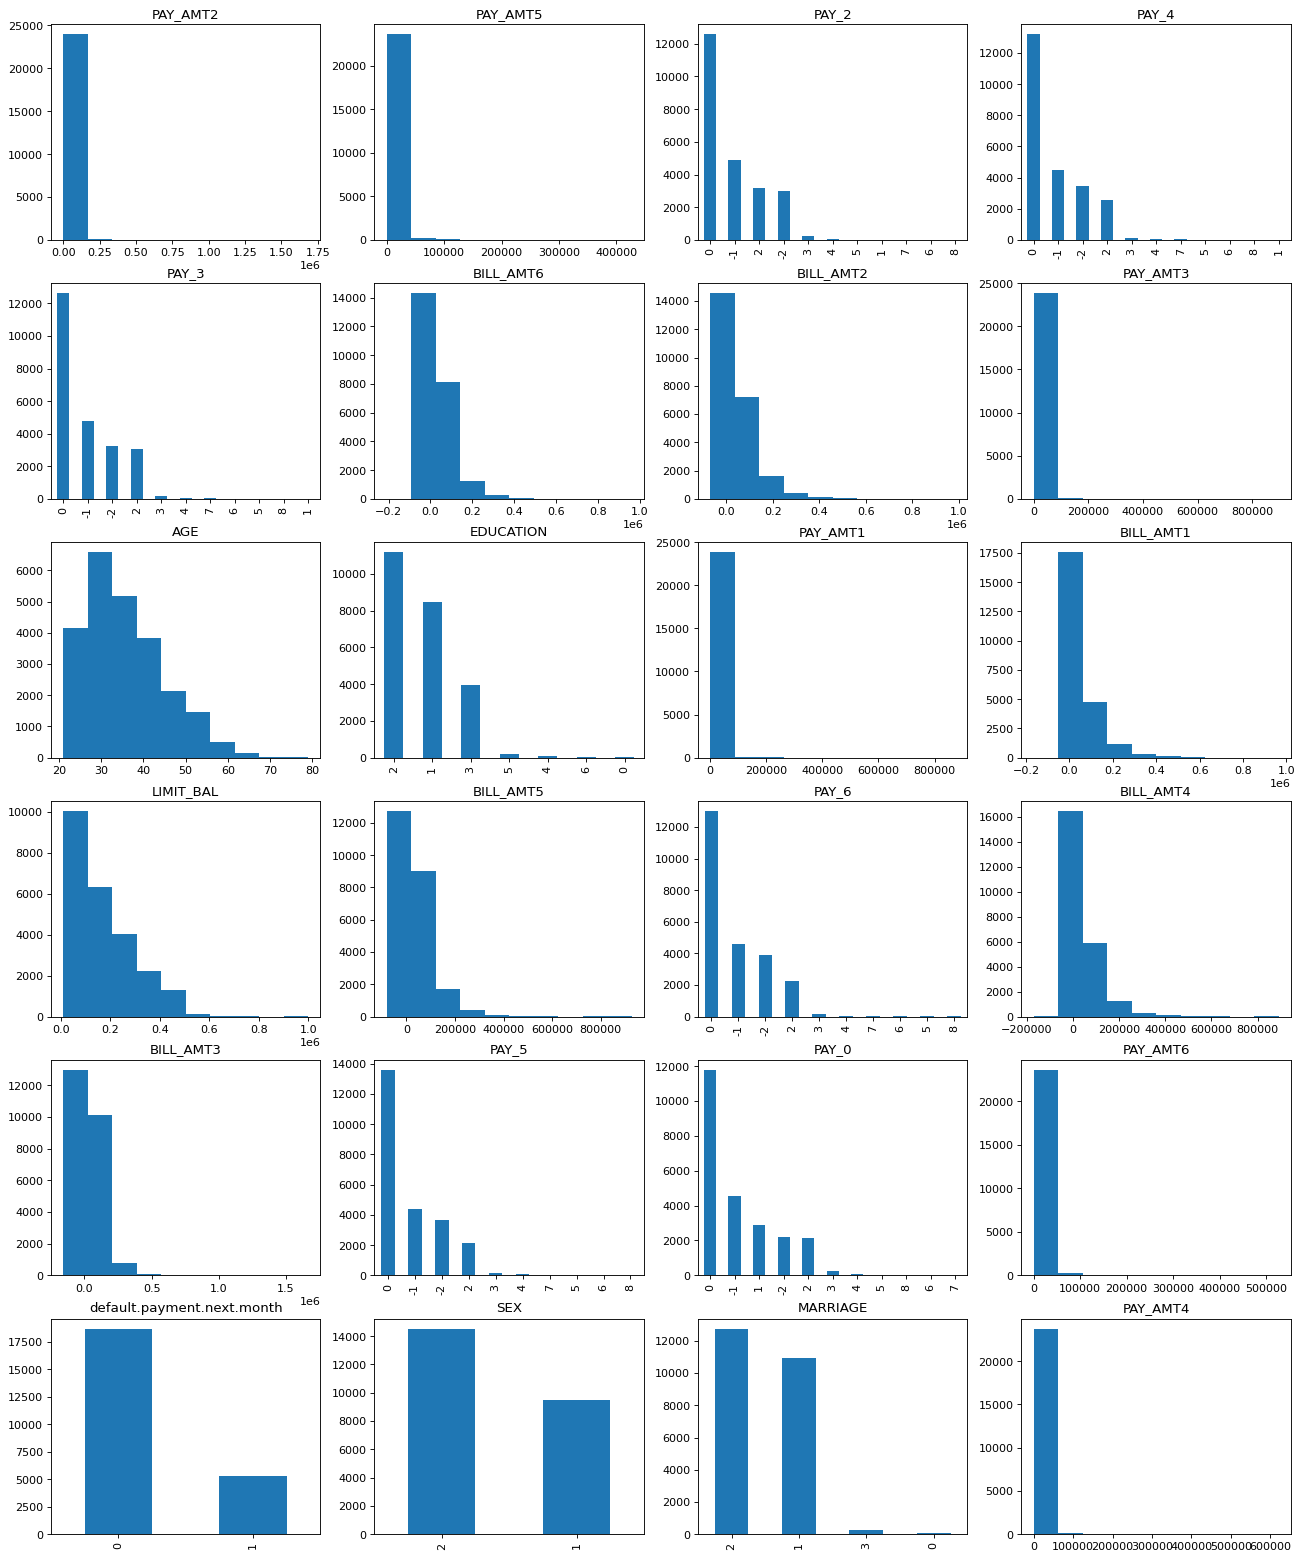

In [30]:
draw_plots()

<h1>Preprocessing</h1>

In [31]:
labels = dataset["default.payment.next.month"]
dataset = dataset.drop(columns=["ID", "default.payment.next.month"])
dataset["SEX"] = dataset["SEX"].astype("category")
dataset["EDUCATION"] = dataset["EDUCATION"].astype("category") 
dataset["MARRIAGE"] = dataset["MARRIAGE"].astype("category") 
dataset["PAY_0"] = dataset["PAY_0"].astype("category") 
dataset["PAY_2"] = dataset["PAY_2"].astype("category") 
dataset["PAY_3"] = dataset["PAY_3"].astype("category") 
dataset["PAY_4"] = dataset["PAY_4"].astype("category") 
dataset["PAY_5"] = dataset["PAY_5"].astype("category")
dataset["PAY_6"] = dataset["PAY_6"].astype("category")
dataset = pd.get_dummies(dataset)
dataset["default.payment.next.month"] = labels

In [32]:
# split dataset in train and test sets
df_train, df_test = train_test_split(dataset, test_size=0.20, stratify=dataset["default.payment.next.month"], random_state=123456789)

# split trainset in train and validation sets
df_train, df_validation = train_test_split(df_train, test_size=0.30, stratify=df_train["default.payment.next.month"], random_state=123456789)

In [33]:
attr_to_normalize = ["LIMIT_BAL",	"AGE",	"BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3", 
                     "BILL_AMT4",	"BILL_AMT5",	"BILL_AMT6",	"PAY_AMT1", "PAY_AMT2",	"PAY_AMT3",	"PAY_AMT4",	"PAY_AMT5",	"PAY_AMT6"]
for attr in list(dataset.columns.values):
  if attr in attr_to_normalize:
    min = df_train[attr].min()
    max = df_train[attr].max()
    df_train[attr]=(df_train[attr] - min) / (max - min)
    df_validation[attr]=(df_validation[attr] - min) / (max - min)
    df_test[attr]=(df_test[attr] - min) / (max - min)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [34]:
smote_nc = SMOTENC(categorical_features=list(range(14,91)), random_state=0)
xbalanced_train, ybalanced_train = smote_nc.fit_resample(df_train.iloc[:,:-1], df_train.iloc[:,-1])
df_train=pd.DataFrame(xbalanced_train, columns=list(dataset.columns.values)[:-1])
df_train["default.payment.next.month"] = ybalanced_train

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


<h1>Classification</h1>

In [35]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def fscore(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

def plot_history(network_history, n_epochs):
    x_plot = list(range(1,n_epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('FScore')
    plt.plot(x_plot, network_history.history['fscore'])
    plt.plot(x_plot, network_history.history['val_fscore'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

<h3>Without normalization</h3>

Epoch 1/50
164/164 - 1s - loss: 0.5708 - fscore: 0.6567 - val_loss: 0.5951 - val_fscore: 0.4546
Epoch 2/50
164/164 - 0s - loss: 0.5166 - fscore: 0.7230 - val_loss: 0.5035 - val_fscore: 0.4758
Epoch 3/50
164/164 - 0s - loss: 0.4958 - fscore: 0.7337 - val_loss: 0.5694 - val_fscore: 0.4613
Epoch 4/50
164/164 - 1s - loss: 0.4831 - fscore: 0.7429 - val_loss: 0.5750 - val_fscore: 0.4742
Epoch 5/50
164/164 - 0s - loss: 0.4748 - fscore: 0.7481 - val_loss: 0.5286 - val_fscore: 0.4652
Epoch 6/50
164/164 - 1s - loss: 0.4685 - fscore: 0.7501 - val_loss: 0.6119 - val_fscore: 0.4451
Epoch 7/50
164/164 - 0s - loss: 0.4627 - fscore: 0.7556 - val_loss: 0.5332 - val_fscore: 0.4521
Epoch 8/50
164/164 - 0s - loss: 0.4569 - fscore: 0.7607 - val_loss: 0.5439 - val_fscore: 0.4489
Epoch 9/50
164/164 - 0s - loss: 0.4563 - fscore: 0.7596 - val_loss: 0.6250 - val_fscore: 0.4394
Epoch 10/50
164/164 - 1s - loss: 0.4486 - fscore: 0.7668 - val_loss: 0.5799 - val_fscore: 0.4400
Epoch 11/50
164/164 - 0s - loss: 0.4428

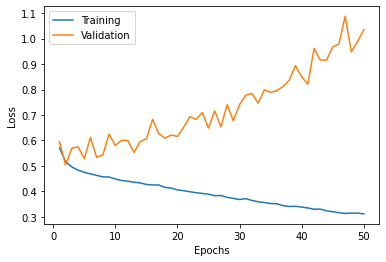

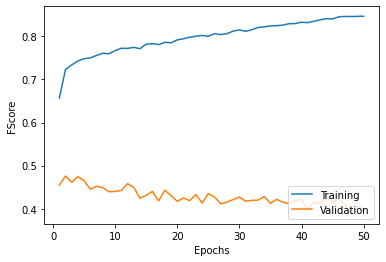

In [36]:
initializer = tf.keras.initializers.GlorotUniform(seed=123456789)
nfeatures = df_train.shape[1] - 1
n_epochs=50
model = Sequential()
model.add(Input(shape=(nfeatures,)))
model.add(Dense(200, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(150, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(100, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(50, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(25, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(1, activation="sigmoid", kernel_initializer=initializer, bias_initializer='zeros'))
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics = [fscore])

network_history = model.fit(np.array(df_train)[:,:-1], np.array(df_train)[:,-1], 
                            batch_size=128,
                            epochs=n_epochs,
                            verbose=2,
                            validation_data=(np.array(df_validation)[:,:-1], 
                                             np.array(df_validation)[:,-1]))

plot_history(network_history, n_epochs)

In [37]:
for layer in range(len(model.get_weights())):
    print('Layer name:', model.weights[layer].name)
    print('Layer weights shape:', model.weights[layer].shape)
    print('Weight:', model.weights[layer], end = '\n\n')
    #print(layer.get_config(), end='\n{}\n'.format('----'*10))
print('Model Output Tensors: ', model.output)

Layer name: dense_24/kernel:0
Layer weights shape: (91, 200)
Weight: <tf.Variable 'dense_24/kernel:0' shape=(91, 200) dtype=float32, numpy=
array([[ 0.28664953,  0.28892127, -0.58610076, ...,  0.3078016 ,
         0.04536515, -0.03802026],
       [ 0.23197572,  0.27049592,  0.19856487, ...,  0.08596268,
         0.159817  , -0.55508274],
       [ 0.0606465 , -0.03963122, -0.29231545, ...,  0.01908026,
        -0.34096578, -0.19095488],
       ...,
       [ 0.18999004,  0.03667746,  0.02043659, ...,  0.11098141,
         0.02415341,  0.02598012],
       [ 0.1879421 ,  0.07921542, -0.14618884, ...,  0.07960115,
        -0.09656002,  0.00894467],
       [ 0.1170391 , -0.07557289, -0.11087216, ...,  0.11650768,
        -0.09892304, -0.03321233]], dtype=float32)>

Layer name: dense_24/bias:0
Layer weights shape: (200,)
Weight: <tf.Variable 'dense_24/bias:0' shape=(200,) dtype=float32, numpy=
array([ 0.09702238, -0.01143263,  0.03652292,  0.03171775,  0.03351539,
       -0.1238961 , -0.00676

<h3>L2 norm regularization</h3>

Epoch 1/50
164/164 - 1s - loss: 2.1259 - fscore: 0.5554 - val_loss: 0.8149 - val_fscore: 0.5034
Epoch 2/50
164/164 - 1s - loss: 0.7195 - fscore: 0.6363 - val_loss: 0.6985 - val_fscore: 0.5015
Epoch 3/50
164/164 - 1s - loss: 0.6731 - fscore: 0.6451 - val_loss: 0.6987 - val_fscore: 0.5040
Epoch 4/50
164/164 - 1s - loss: 0.6681 - fscore: 0.6474 - val_loss: 0.7389 - val_fscore: 0.4734
Epoch 5/50
164/164 - 1s - loss: 0.6631 - fscore: 0.6537 - val_loss: 0.6499 - val_fscore: 0.4976
Epoch 6/50
164/164 - 1s - loss: 0.6614 - fscore: 0.6585 - val_loss: 0.7432 - val_fscore: 0.4517
Epoch 7/50
164/164 - 1s - loss: 0.6628 - fscore: 0.6659 - val_loss: 0.6531 - val_fscore: 0.5141
Epoch 8/50
164/164 - 1s - loss: 0.6584 - fscore: 0.6627 - val_loss: 0.6531 - val_fscore: 0.4981
Epoch 9/50
164/164 - 1s - loss: 0.6574 - fscore: 0.6661 - val_loss: 0.6958 - val_fscore: 0.5043
Epoch 10/50
164/164 - 1s - loss: 0.6598 - fscore: 0.6676 - val_loss: 0.6408 - val_fscore: 0.4956
Epoch 11/50
164/164 - 1s - loss: 0.6592

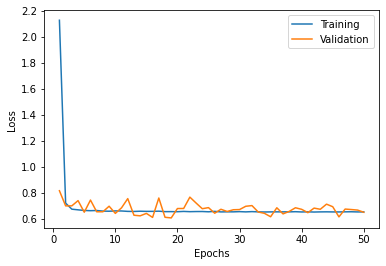

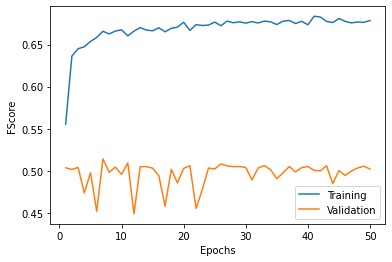

In [38]:
initializer = tf.keras.initializers.GlorotUniform(seed=123456789)
nfeatures = df_train.shape[1] - 1
n_epochs=50
model = Sequential()
model.add(Input(shape=(nfeatures,)))
model.add(Dense(200, activation="relu", kernel_regularizer=regularizers.l2(), kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(150, activation="relu", kernel_regularizer=regularizers.l2(), kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(100, activation="relu", kernel_regularizer=regularizers.l2(), kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(50, activation="relu", kernel_regularizer=regularizers.l2(), kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(25, activation="relu", kernel_regularizer=regularizers.l2(), kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dense(1, activation="sigmoid", kernel_regularizer=regularizers.l2(), kernel_initializer=initializer, bias_initializer='zeros'))
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics = [fscore])

network_history = model.fit(np.array(df_train)[:,:-1], np.array(df_train)[:,-1], 
                            batch_size=128,
                            epochs=n_epochs,
                            verbose=2,
                            validation_data=(np.array(df_validation)[:,:-1], 
                                             np.array(df_validation)[:,-1]))

plot_history(network_history, n_epochs)

In [39]:
for layer in range(len(model.get_weights())):
    print('Layer name:', model.weights[layer].name)
    print('Layer weights shape:', model.weights[layer].shape)
    print('Weight:', model.weights[layer], end = '\n\n')
    #print(layer.get_config(), end='\n{}\n'.format('----'*10))
print('Model Output Tensors: ', model.output)

Layer name: dense_30/kernel:0
Layer weights shape: (91, 200)
Weight: <tf.Variable 'dense_30/kernel:0' shape=(91, 200) dtype=float32, numpy=
array([[ 3.0020450e-35, -3.4283428e-35, -1.8471862e-34, ...,
         1.8804631e-34, -1.6726620e-34, -5.2233610e-34],
       [-2.2018625e-34,  2.0140599e-34, -2.7969482e-35, ...,
        -2.3846189e-35, -2.0765016e-34, -4.6279754e-34],
       [-2.1782239e-34,  3.5512825e-34, -2.3944774e-34, ...,
        -5.8140134e-34,  5.4283838e-34, -1.7187247e-34],
       ...,
       [ 4.5491843e-34,  1.6480862e-34, -2.8456239e-35, ...,
         4.5616271e-34, -2.2810489e-34,  3.7565992e-34],
       [-2.8741241e-34, -8.5810628e-36,  1.2250267e-34, ...,
        -1.7915037e-34,  2.3594885e-34,  9.8931292e-35],
       [-7.7819844e-35,  4.6554930e-34, -4.8671660e-34, ...,
         1.9210741e-34,  2.5897270e-34, -4.0736568e-34]], dtype=float32)>

Layer name: dense_30/bias:0
Layer weights shape: (200,)
Weight: <tf.Variable 'dense_30/bias:0' shape=(200,) dtype=float32,

<h3>Dropout regularization</h3>

Epoch 1/50
164/164 - 1s - loss: 0.6760 - fscore: 0.5576 - val_loss: 0.6299 - val_fscore: 0.4965
Epoch 2/50
164/164 - 1s - loss: 0.6221 - fscore: 0.6105 - val_loss: 0.6217 - val_fscore: 0.5019
Epoch 3/50
164/164 - 1s - loss: 0.5988 - fscore: 0.6461 - val_loss: 0.5709 - val_fscore: 0.5015
Epoch 4/50
164/164 - 1s - loss: 0.5801 - fscore: 0.6774 - val_loss: 0.5760 - val_fscore: 0.4763
Epoch 5/50
164/164 - 1s - loss: 0.5650 - fscore: 0.6979 - val_loss: 0.5709 - val_fscore: 0.4617
Epoch 6/50
164/164 - 1s - loss: 0.5549 - fscore: 0.7132 - val_loss: 0.5514 - val_fscore: 0.4809
Epoch 7/50
164/164 - 1s - loss: 0.5436 - fscore: 0.7192 - val_loss: 0.5504 - val_fscore: 0.4867
Epoch 8/50
164/164 - 1s - loss: 0.5360 - fscore: 0.7229 - val_loss: 0.5724 - val_fscore: 0.4496
Epoch 9/50
164/164 - 0s - loss: 0.5296 - fscore: 0.7237 - val_loss: 0.5696 - val_fscore: 0.4740
Epoch 10/50
164/164 - 1s - loss: 0.5261 - fscore: 0.7294 - val_loss: 0.5450 - val_fscore: 0.4693
Epoch 11/50
164/164 - 1s - loss: 0.5221

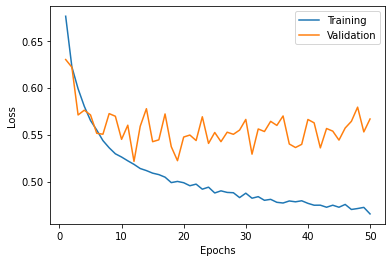

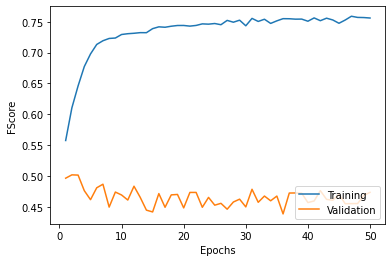

In [40]:
initializer = tf.keras.initializers.GlorotUniform(seed=123456789)
nfeatures = df_train.shape[1] - 1
n_epochs=50
model = Sequential()
model.add(Input(shape=(nfeatures,)))
model.add(Dense(200, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(150, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(100, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(25, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", kernel_initializer=initializer, bias_initializer='zeros'))
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics = [fscore])

network_history = model.fit(np.array(df_train)[:,:-1], np.array(df_train)[:,-1], 
                            batch_size=128,
                            epochs=n_epochs,
                            verbose=2,
                            validation_data=(np.array(df_validation)[:,:-1], 
                                             np.array(df_validation)[:,-1]))

plot_history(network_history, n_epochs)

In [41]:
for layer in range(len(model.get_weights())):
    print('Layer name:', model.weights[layer].name)
    print('Layer weights shape:', model.weights[layer].shape)
    print('Weight:', model.weights[layer], end = '\n\n')
    #print(layer.get_config(), end='\n{}\n'.format('----'*10))
print('Model Output Tensors: ', model.output)

Layer name: dense_36/kernel:0
Layer weights shape: (91, 200)
Weight: <tf.Variable 'dense_36/kernel:0' shape=(91, 200) dtype=float32, numpy=
array([[ 0.24155363,  0.5610695 , -0.29822212, ..., -0.07072327,
         0.11737074,  0.01378633],
       [-0.03969217, -0.09720489,  0.13213539, ..., -0.08119646,
         0.07649896, -0.20657553],
       [ 0.05103572, -0.10196367, -0.22255743, ...,  0.03121857,
        -0.23762761, -0.22370587],
       ...,
       [ 0.228888  , -0.13142663,  0.0939423 , ...,  0.01420017,
        -0.02123774,  0.1147323 ],
       [ 0.04231867, -0.01334784, -0.21313044, ...,  0.12512298,
        -0.11983113, -0.07549217],
       [ 0.1170391 , -0.07557289, -0.11087216, ...,  0.13441512,
        -0.09892304, -0.02222866]], dtype=float32)>

Layer name: dense_36/bias:0
Layer weights shape: (200,)
Weight: <tf.Variable 'dense_36/bias:0' shape=(200,) dtype=float32, numpy=
array([ 5.95925115e-02, -1.51935920e-01,  1.99634116e-02, -3.33295278e-02,
       -1.56312659e-01, -

In [42]:
df_train = df_train.append(df_validation)

In [43]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
network_history = model.fit(np.array(df_train)[:,:-1], np.array(df_train)[:,-1], 
                            batch_size=128,
                            epochs=n_epochs,
                            verbose=2,
                            callbacks=[callback])

Epoch 1/50
209/209 - 1s - loss: 0.4968 - fscore: 0.6943
Epoch 2/50
209/209 - 1s - loss: 0.4930 - fscore: 0.7014
Epoch 3/50
209/209 - 1s - loss: 0.4871 - fscore: 0.6979
Epoch 4/50
209/209 - 1s - loss: 0.4894 - fscore: 0.6985
Epoch 5/50
209/209 - 1s - loss: 0.4843 - fscore: 0.7040
Epoch 6/50
209/209 - 1s - loss: 0.4823 - fscore: 0.6986
Epoch 7/50
209/209 - 1s - loss: 0.4848 - fscore: 0.7081
Epoch 8/50
209/209 - 1s - loss: 0.4850 - fscore: 0.6995
Epoch 9/50
209/209 - 1s - loss: 0.4806 - fscore: 0.7033
Epoch 10/50
209/209 - 1s - loss: 0.4844 - fscore: 0.7050
Epoch 11/50
209/209 - 1s - loss: 0.4848 - fscore: 0.7030
Epoch 12/50
209/209 - 1s - loss: 0.4828 - fscore: 0.6990


In [44]:
predictions = model.predict_classes(np.array(df_test)[:,:-1])
ground_truth = df_test["default.payment.next.month"]
print("F1 score: %f" % f1_score(ground_truth, predictions, pos_label=1))
#tn, fp, fn, tp = confusion_matrix(predictions, np.array(df_test)[:,-1]).ravel()

F1 score: 0.475230


<h1>Build the model</h1>

In [45]:
dataset.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,...,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default.payment.next.month
count,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,167226.653333,35.494375,50927.468417,48914.770500,4.675708e+04,43013.532167,40150.333000,38763.540458,5670.826542,5.961101e+03,5258.246500,4880.847125,4818.849250,5159.462125,0.395083,0.604917,0.000417,0.353375,0.466083,0.164958,0.004042,0.009333,0.001792,0.001875,0.455917,0.531125,0.011083,0.091875,0.190500,0.490958,0.121542,0.089083,0.011417,0.002500,0.000708,0.000458,0.000333,0.000625,0.124792,0.203125,...,0.000083,0.126958,0.007750,0.002583,0.000667,0.000667,0.000875,0.000083,0.145500,0.18800,0.549333,0.000042,0.105667,0.006000,0.002250,0.001083,0.000167,0.001875,0.000083,0.151958,0.182833,0.566125,0.087833,0.005792,0.002750,0.000667,0.000125,0.001875,0.000042,0.162875,0.191750,0.541792,0.092875,0.006292,0.001792,0.000458,0.000583,0.001500,0.000083,0.221792
std,129734.959196,9.235160,73400.840274,70923.493353,6.926506e+04,64069.494705,60635.882129,59281.986863,17084.401034,2.428412e+04,18242.618988,16304.718844,15619.425964,17458.604219,0.488879,0.488879,0.020409,0.478028,0.498859,0.371151,0.063447,0.096159,0.042291,0.043262,0.498063,0.499041,0.104695,0.288855,0.392704,0.499929,0.326763,0.284870,0.106239,0.049939,0.026606,0.021404,0.018255,0.024993,0.330489,0.402333,...,0.009129,0.332933,0.087694,0.050762,0.025812,0.025812,0.029568,0.009129,0.352612,0.39072,0.497571,0.006455,0.307417,0.077229,0.047382,0.032897,0.012909,0.043262,0.009129,0.358988,0.386538,0.495619,0.283058,0.075884,0.052369,0.025812,0.011180,0.043262,0.006455,0.369259,0.393686,0.498261,0.290263,0.079072,0.042291,0.021404,0.024146,0.038702,0.009129,0.415460
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-209051.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [46]:
attr_to_normalize = ["LIMIT_BAL",	"AGE",	"BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3", 
                     "BILL_AMT4",	"BILL_AMT5",	"BILL_AMT6",	"PAY_AMT1", "PAY_AMT2",	"PAY_AMT3",	"PAY_AMT4",	"PAY_AMT5",	"PAY_AMT6"]
for attr in list(dataset.columns.values):
  if attr in attr_to_normalize:
    min = dataset[attr].min()
    max = dataset[attr].max()
    dataset[attr]=(dataset[attr] - min) / (max - min)

dataset.describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,...,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default.payment.next.month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,0.158815,0.249903,0.191584,0.112642,0.112016,0.200656,0.120460,0.211678,0.006492,0.003539,0.005868,0.007860,0.011298,0.009788,0.395083,0.604917,0.000417,0.353375,0.466083,0.164958,0.004042,0.009333,0.001792,0.001875,0.455917,0.531125,0.011083,0.091875,0.190500,0.490958,0.121542,0.089083,0.011417,0.002500,0.000708,0.000458,0.000333,0.000625,0.124792,0.203125,...,0.000083,0.126958,0.007750,0.002583,0.000667,0.000667,0.000875,0.000083,0.145500,0.18800,0.549333,0.000042,0.105667,0.006000,0.002250,0.001083,0.000167,0.001875,0.000083,0.151958,0.182833,0.566125,0.087833,0.005792,0.002750,0.000667,0.000125,0.001875,0.000042,0.162875,0.191750,0.541792,0.092875,0.006292,0.001792,0.000458,0.000583,0.001500,0.000083,0.221792
std,0.131045,0.159227,0.064951,0.067308,0.038029,0.060353,0.060125,0.050637,0.019557,0.014418,0.020359,0.026256,0.036620,0.033119,0.488879,0.488879,0.020409,0.478028,0.498859,0.371151,0.063447,0.096159,0.042291,0.043262,0.498063,0.499041,0.104695,0.288855,0.392704,0.499929,0.326763,0.284870,0.106239,0.049939,0.026606,0.021404,0.018255,0.024993,0.330489,0.402333,...,0.009129,0.332933,0.087694,0.050762,0.025812,0.025812,0.029568,0.009129,0.352612,0.39072,0.497571,0.006455,0.307417,0.077229,0.047382,0.032897,0.012909,0.043262,0.009129,0.358988,0.386538,0.495619,0.283058,0.075884,0.052369,0.025812,0.011180,0.043262,0.006455,0.369259,0.393686,0.498261,0.290263,0.079072,0.042291,0.021404,0.024146,0.038702,0.009129,0.415460
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040404,0.120690,0.149649,0.069058,0.0

In [47]:
smote_nc = SMOTENC(categorical_features=list(range(14,91)), random_state=0)
xbalanced_dataset, ybalanced_dataset = smote_nc.fit_resample(dataset.iloc[:,:-1], dataset.iloc[:,-1])
dataset=pd.DataFrame(xbalanced_dataset, columns=list(dataset.columns.values)[:-1])
dataset["default.payment.next.month"] = ybalanced_dataset
dataset.describe()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,...,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default.payment.next.month
count,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,...,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000,37354.000000
mean,0.144566,0.252158,0.190412,0.111746,0.111576,0.200152,0.120225,0.211647,0.005461,0.002916,0.004990,0.006673,0.009871,0.008362,0.400118,0.599882,0.000268,0.324597,0.488890,0.146410,0.002597,0.005997,0.001151,0.001205,0.471516,0.517026,0.007255,0.077047,0.172994,0.417787,0.127242,0.153531,0.011565,0.001713,0.000455,0.000348,0.000214,0.000509,0.116694,0.182685,...,0.000054,0.179874,0.006532,0.002436,0.000428,0.000535,0.001044,0.000054,0.136344,0.169299,0.520988,0.000027,0.150506,0.004953,0.001847,0.000910,0.000107,0.002945,0.000054,0.142341,0.165043,0.544092,0.127189,0.004765,0.002864,0.000428,0.000080,0.002945,0.000027,0.150426,0.172538,0.522862,0.130107,0.005247,0.001660,0.000294,0.000455,0.002276,0.000054,0.500000
std,0.126660,0.162396,0.063716,0.066321,0.037303,0.059613,0.059667,0.050014,0.016587,0.011871,0.017649,0.022478,0.033347,0.029511,0.489929,0.489929,0.016360,0.468230,0.499883,0.353522,0.050893,0.077207,0.033909,0.034688,0.499195,0.499717,0.084867,0.266669,0.378247,0.493201,0.333248,0.360503,0.106919,0.041358,0.021329,0.018652,0.014633,0.022548,0.321060,0.386413,...,0.007317,0.384087,0.080558,0.049298,0.020692,0.023133,0.032296,0.007317,0.343158,0.375021,0.499566,0.005174,0.357571,0.070201,0.042940,0.030156,0.010348,0.054187,0.007317,0.349404,0.371224,0.498059,0.333188,0.068867,0.053445,0.020692,0.008961,0.054187,0.005174,0.357493,0.377853,0.499484,0.336425,0.072248,0.040707,0.017158,0.021329,0.047649,0.007317,0.500007
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.040404,0.120690,0.149751,0.069135

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

initializer = tf.keras.initializers.GlorotUniform(seed=123456789)
nfeatures = dataset.shape[1] - 1
n_epochs=50
model = Sequential()
model.add(Input(shape=(nfeatures,)))
model.add(Dense(200, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(150, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(100, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(50, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(25, activation="relu", kernel_initializer=initializer, bias_initializer='zeros'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid", kernel_initializer=initializer, bias_initializer='zeros'))
model.compile(optimizer="adam", loss='binary_crossentropy', 
              metrics = [fscore])

network_history = model.fit(np.array(dataset)[:,:-1], np.array(dataset)[:,-1], 
                            batch_size=128,
                            epochs=n_epochs,
                            verbose=2,
                            callbacks=[callback])

Epoch 1/50
292/292 - 1s - loss: 0.6555 - fscore: 0.5677
Epoch 2/50
292/292 - 1s - loss: 0.6012 - fscore: 0.6383
Epoch 3/50
292/292 - 1s - loss: 0.5829 - fscore: 0.6724
Epoch 4/50
292/292 - 1s - loss: 0.5686 - fscore: 0.6862
Epoch 5/50
292/292 - 1s - loss: 0.5585 - fscore: 0.6988
Epoch 6/50
292/292 - 1s - loss: 0.5527 - fscore: 0.7012
Epoch 7/50
292/292 - 1s - loss: 0.5435 - fscore: 0.7029
Epoch 8/50
292/292 - 1s - loss: 0.5386 - fscore: 0.7087
Epoch 9/50
292/292 - 1s - loss: 0.5324 - fscore: 0.7122
Epoch 10/50
292/292 - 1s - loss: 0.5277 - fscore: 0.7132
Epoch 11/50
292/292 - 1s - loss: 0.5269 - fscore: 0.7144
Epoch 12/50
292/292 - 1s - loss: 0.5249 - fscore: 0.7122
Epoch 13/50
292/292 - 1s - loss: 0.5196 - fscore: 0.7174
Epoch 14/50
292/292 - 1s - loss: 0.5190 - fscore: 0.7200
Epoch 15/50
292/292 - 1s - loss: 0.5182 - fscore: 0.7165
Epoch 16/50
292/292 - 1s - loss: 0.5152 - fscore: 0.7202
Epoch 17/50
292/292 - 1s - loss: 0.5132 - fscore: 0.7221
Epoch 18/50
292/292 - 1s - loss: 0.5104 

<h1>Make the predictions</h1>

In [49]:
# use trick to have the same columns in Xtest as dataset after binarization
Xtest=pd.read_csv("/content/X_test.csv",sep=",")
dataset=pd.read_csv("/content/X_train.csv",sep=",")
Xtest = dataset.append(Xtest)
Xtest = Xtest.reset_index(drop=True) 

Xtest = Xtest.drop(columns=["ID"])
Xtest["SEX"] = Xtest["SEX"].astype("category")
Xtest["EDUCATION"] = Xtest["EDUCATION"].astype("category") 
Xtest["MARRIAGE"] = Xtest["MARRIAGE"].astype("category")
Xtest["PAY_0"] = Xtest["PAY_0"].astype("category") 
Xtest["PAY_2"] = Xtest["PAY_2"].astype("category") 
Xtest["PAY_3"] = Xtest["PAY_3"].astype("category") 
Xtest["PAY_4"] = Xtest["PAY_4"].astype("category") 
Xtest["PAY_5"] = Xtest["PAY_5"].astype("category")
Xtest["PAY_6"] = Xtest["PAY_6"].astype("category")
Xtest = pd.get_dummies(Xtest)

Xtest = Xtest.drop(list(range(0, dataset.shape[0])), axis=0)

attr_to_normalize = ["LIMIT_BAL",	"AGE",	"BILL_AMT1",	"BILL_AMT2",	"BILL_AMT3", 
                     "BILL_AMT4",	"BILL_AMT5",	"BILL_AMT6",	"PAY_AMT1", "PAY_AMT2",	"PAY_AMT3",	"PAY_AMT4",	"PAY_AMT5",	"PAY_AMT6"]
for attr in list(dataset.columns.values):
  if attr in attr_to_normalize:
    min = dataset[attr].min()
    max = dataset[attr].max()
    Xtest[attr]=(Xtest[attr] - min) / (max - min)

predictions = np.transpose(model.predict(np.array(Xtest))).flatten()

file = open("Simone_Paolo_Mottadelli_820786_score2.txt", "w")
for i in range(0, len(predictions)):
  file.write(str(int(np.round(predictions[i]))) + "\n")
file.close()